<a href="https://colab.research.google.com/github/puckgroen/TM10007_PROJECT/blob/master/assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TM10007 Assignment template

In [1]:
# Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/karinvangarderen/tm10007_project.git

In [2]:
# Import packages

# General packages
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn import datasets as ds
import seaborn

# Classifiers
from sklearn import model_selection
from sklearn import metrics
from sklearn import feature_selection 
from sklearn import preprocessing
from sklearn import neighbors
from sklearn import svm
from sklearn import decomposition
from sklearn.impute import KNNImputer

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA, KernelPCA
from sklearn.kernel_approximation import RBFSampler

In [3]:
# preprocessing function

def data_preprocessing(X_train, y_train):
    '''Data preprocessing'''

    # 1. Scaling (standard, min max, robust)

    # Scale the data to be normal
    scaler = preprocessing.StandardScaler()
    # scaler = preprocessing.MinMaxScaler()
    # scaler = preprocessing.RobustScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)

    # 2. Feature selection/extraction
    # Create the Recursive Feature Elimination object and compute a cross-validated score.
    svc = svm.SVC(kernel="linear")

    # classifications
    rfecv = feature_selection.RFECV(
        estimator=svc, step=1, 
        cv=model_selection.StratifiedKFold(4),
        scoring='roc_auc')
    rfecv.fit(X_train_scaled, y_train)

    # Plot number of features VS. cross-validation scores
    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score (nb of correct classifications)")
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    plt.show()
    print("Optimal number of features : %d" % rfecv.n_features_)

    # 3. PCA
    n_selected_features = rfecv.n_features_
    n_samples = len(X_train.index)
    n_components = min(n_samples, n_selected_features)
    pca = decomposition.PCA(n_components)
    pca.fit(X_train_scaled)
    X_train_pca = pca.transform(X_train_scaled)

    # print(X_train_pca)
    # X_train_pca.shape

    # # 4. Imputation missing data
    # missing_values=[0.0, 1.0]
    # for elem in missing_values:
    #     imputer = KNNImputer(missing_values=elem, n_neighbors=5, weights='uniform')
    #     X_train_imputed = imputer.fit_transform(X_train_pca)

    # print(X_train_imputed)
    # X_train_imputed.shape

    return X_train_pca

The number of samples: 113
The number of features: 159


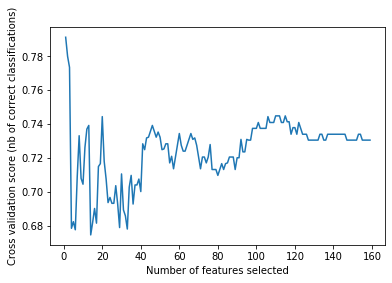

Optimal number of features : 1


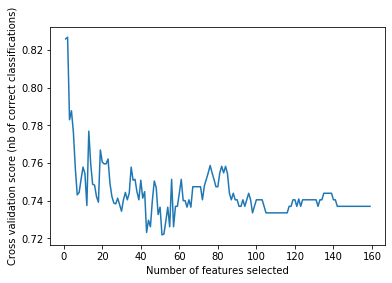

Optimal number of features : 2


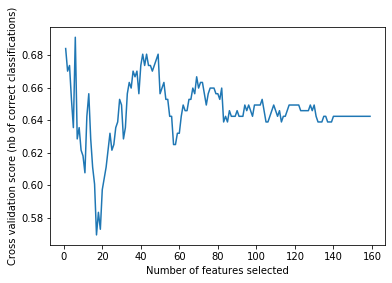

Optimal number of features : 6


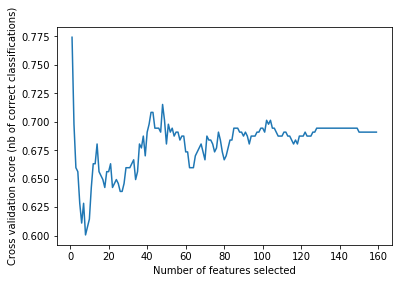

Optimal number of features : 1


In [4]:
# Data splitting

# # Data imputation (NOG OP VERKEERDE PLEK) --> niet meer nodig
# split_X_train[split_X_train == 1] = np.nan
# split_X_train[split_X_train == 0.0] = np.nan

# for column in split_X_train:
#     print(column)
#     print(split_X_train[column].isnull().sum(axis = 0))

# Data loading

from hn.load_data import load_data
data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of features: {len(data.columns)-1}')
y_labels = data['label']
del data['label']

y = sklearn.preprocessing.label_binarize(y_labels, ['T12', 'T34']) # 0 now stands for T12 and 1 for T34
y = [i[0] for i in y]
y = np.array(y)

cv_4fold = model_selection.StratifiedKFold(n_splits=4, shuffle=True)
split_X_train, split_X_test, split_y_train, split_y_test = train_test_split(data, y,
                                                    stratify=y, 
                                                    test_size=0.2)

# Loop over the folds
for training_index, validation_index in cv_4fold.split(split_X_train, split_y_train):
    X_validation = split_X_train.iloc[validation_index]
    y_validation = split_y_train[validation_index]
    X_train = split_X_train.iloc[training_index]
    y_train = split_y_train[training_index]
    #print(f'Validation size in current fold = {len(X_validation)}')
    
    #apply preprocessing
    X_train_pca = data_preprocessing(X_train, y_train)

        #print(X_train)

The data has 159 features and 113 samples/subjects. The labels are given as either T12 (low) or T34 (high). 

The aim of this study is to predict the T-stage (high/low) in patients with H&N cancer based on features, extracted from CT. A good performance on this dataset would be above 70% mean accuracy.

# Classifiers

In [14]:
# Create some classifiers
#svmlin = SVC(kernel='linear', gamma='scale')
#svmrbf = SVC(kernel='rbf', gamma='scale')
#svmpoly = SVC(kernel='poly', degree=3, gamma='scale')
#homemade_random_forest = BaggingClassifier(DecisionTreeClassifier())
#voting_ensemble = VotingClassifier(
#    estimators=[('KNN', KNeighborsClassifier()), ('tree', DecisionTreeClassifier()), ('rf', RandomForestClassifier())],
#    voting='soft')

clsfs = [LinearDiscriminantAnalysis(),QuadraticDiscriminantAnalysis(),GaussianNB(), 
         LogisticRegression(), SGDClassifier(), KNeighborsClassifier()]
clsfs_fit = list()

# Fit the classifiers
auc_list = []
metric_list = []
for clf in clsfs:
    clf.fit(X_train_imputed, y_train)
    y_pred = clf.predict(X_train_imputed)
    clsfs_fit.append(clf)
    # Calculate metrics
    if hasattr(clf, 'predict_proba'):
    # The first column gives the probability for class = 0, so we take
    # the second which gives the probability class = 1:
        y_score = clf.predict_proba(X_train_imputed)[:, 1]
    else:
       y_score = y_pred

# The hasattr function checks whether an object, function or package has
# a certain attribute. This attribute can be a subfunction, or again an
# object or function, but also things like scalars or strings.
   
    auc=metrics.roc_auc_score(y_train, y_score)
    accuracy=metrics.accuracy_score(y_train, y_pred)
    F1=metrics.f1_score(y_train, y_pred)
    precision=metrics.precision_score(y_train, y_pred)
    recall=metrics.recall_score(y_train, y_pred)

    auc_list.append(auc)
    metric_list.append(type(clf))

# print the scores per classifier
    print(type(clf))
    print('Acc:' +str(accuracy))
    print('AUC:' +str(auc))
    print('F1:' +str(F1))
    print('precision:' +str(precision))
    print('recall:' +str(recall))

auc_list.sort(reverse=True)
print(auc_list)
print(metric_list)


# Choose the two with the highest accuracy




<class 'sklearn.discriminant_analysis.LinearDiscriminantAnalysis'>
Acc:0.6911764705882353
AUC:0.7385281385281386
F1:0.6557377049180327
precision:0.7142857142857143
recall:0.6060606060606061
<class 'sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis'>
Acc:0.6764705882352942
AUC:0.7385281385281386
F1:0.6333333333333334
precision:0.7037037037037037
recall:0.5757575757575758
<class 'sklearn.naive_bayes.GaussianNB'>
Acc:0.6764705882352942
AUC:0.7385281385281386
F1:0.6333333333333334
precision:0.7037037037037037
recall:0.5757575757575758
<class 'sklearn.linear_model._logistic.LogisticRegression'>
Acc:0.6911764705882353
AUC:0.7385281385281386
F1:0.6666666666666666
precision:0.7
recall:0.6363636363636364
<class 'sklearn.linear_model._stochastic_gradient.SGDClassifier'>
Acc:0.6911764705882353
AUC:0.687878787878788
F1:0.6440677966101696
precision:0.7307692307692307
recall:0.5757575757575758
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Acc:0.6911764705882353
AUC:0.785